In [1]:
import numpy as np
import scipy 
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
import matplotlib.pyplot as plt
import scipy.optimize as optim
import pysal

C:\Users\Alex\Anaconda3\lib\site-packages\pysal\lib\weights\util.py:19: UserWarning: geopandas not available. Some functionality will be disabled.
  warn('geopandas not available. Some functionality will be disabled.')
C:\Users\Alex\Anaconda3\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
def make_matrix(rows, cols):
    n = rows*cols
    M = np.zeros((n,n))
    for r in range(rows):
        for c in range(cols):
            i = r*cols + c
            # Two inner diagonals
            if c > 0: M[i-1,i] = M[i,i-1] = 1
            # Two outer diagonals
            if r > 0: M[i-cols,i] = M[i,i-cols] = 1
                
    return M

In [3]:
def euler_char(A,dim1,dim2,thresh):
    Betti1 = []
    edge = []
    vert = []
    com = []
    As = []
    Ms = []
    for t in thresh:
        
        M = make_matrix(dim1,dim2)
        
        #Binary Image
        binary = (A <= t)*1
        #Adjust Adjaceny Matrix
        count = 0
        for i in range(np.shape(A)[1]):
            for j in range(np.shape(A)[0]):
                if binary[j,i] == 0:
                    M[count,:] = 0
                    M[:,count] = 0
                count += 1
                
        #Number Edges
        Edges = np.sum(M)/2
        
        #Number Vertices
        Vertices = np.sum(binary)
        
        removed_Vertices = np.shape(M)[0] - Vertices
        
        #Number Connected Components
        graph = csr_matrix(M)
        n_comp = connected_components(csgraph = graph, directed = False, return_labels = False)
        n_comp = n_comp - removed_Vertices
        
        #Betti 1
        B1 = n_comp - Vertices + Edges
        
        Betti1.append(B1)
        
        edge.append(Edges)
        
        vert.append(Vertices)
        
        com.append(n_comp)
        
        As.append(binary)
        
        Ms.append(M)
        
    return Betti1

In [4]:
U = 30
m = np.linspace(-1, 1, U)    # 60 points between -1 and 1
delta = m[1] - m[0]              # delta^2 is the area of each grid cell
(x, y) = np.meshgrid(m, m)       # Create the mesh

M = make_matrix(30,30)
thresh = np.arange(0.05,1,.05)


# Create the matrix of weigthts
w = pysal.lib.weights.lat2W(M.shape[0], M.shape[1])




def logistic(t,a,b,c):
    return c/(1+a*np.exp(-b*t))

def data_col(sigma,numgauss,points):
    allker = []
    ker = 0
    for j in range(points):
        for i in range(numgauss):
            k = np.random.uniform(-1,1,1)
            j = np.random.uniform(-1,1,1)
            norm_constant = 1 / (2 * np.pi * sigma**2)
            rhs = np.exp(-.5 * ((x + j)**2 + (y + k)**2) / sigma**2)
            kers = norm_constant * rhs
            ker = kers + ker
        ker = (ker - np.min(ker))/(np.max(ker) - np.min(ker))
        allker.append(ker)
        
    return allker

def fit_param(Data,M,thresh):
    X = np.vstack([np.ones(len(thresh)),thresh,thresh**2,thresh**3,thresh**4]).T
    psuedo = np.linalg.inv(X.T@X)@X.T
    params = []
    grads = []
    ys = []
    for i in range(len(Data)):
        M = make_matrix(U,U)
        y = np.vstack(euler_char(Data[i],U,U,thresh))
        param = psuedo@y
        params.append(param)
        grad = param[1] + param[2]*2*thresh + param[3]*thresh**2
        grads.append(np.max(grad))
        ys.append(y)
    return params,grads,ys

def fit_param_leg(Data,M,thresh):
    x = thresh
    params = []
    y = []
    for i in range(len(Data)):
        M = make_matrix(U,U)
        y = np.vstack(euler_char(Data[i],U,U,thresh))
        param = np.polynomial.legendre.legfit(thresh,y,4)
        params.append(param)
        ys.append(y)
    return params,ys

def fit_log(Data,M,thresh,w):
    x = thresh
    params = []
    ys = []
    Moran = []
    for i in range(len(Data)):
        M = make_matrix(U,U)
        w = pysal.lib.weights.lat2W(Data[i].shape[0], Data[i].shape[1])
        mi = pysal.explore.esda.moran.Moran(Data[i], w)
        y = np.vstack(euler_char(Data[i],U,U,thresh))
        p0 = np.random.exponential(size = 3)
        bounds = (0,[1000000000,30,20000])
        x = thresh
        y = np.array(np.hstack(y))
        y = (y - y.min())/(y.max() - y.min())
        (a,b,c),cov = optim.curve_fit(logistic,x,y,bounds = bounds, p0=p0)
        param = [a,b,c]
        params.append(param)
        ys.append(y)
        Moran.append(mi.I)
    return params,ys,Moran

In [5]:
Data1 = data_col(0.06,300,300)
Data2 = data_col(.06,600,300)

In [6]:
Param1,y1,Moran1 = fit_log(Data1,M,thresh,w)
Param2,y2,Moran2 = fit_log(Data2,M,thresh,w)
np.shape(Param1)

(300, 3)

In [7]:
Param11 = np.vstack(Param1).T
print(np.shape(Param11))
# grad11 = np.hstack(grad1)
Param21 = np.vstack(Param2).T
print(np.shape(Param21))
# grad12 = np.hstack(grad2)

(3, 300)
(3, 300)


278
197


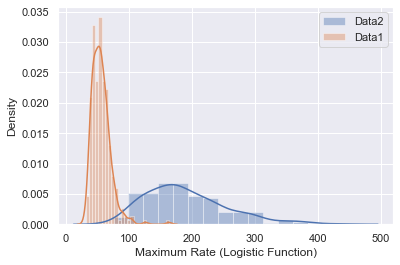

In [62]:
import seaborn as sns
sns.set()
sns.distplot(Param21[0,:],label = "Data2")
sns.distplot(Param11[0,:], label = "Data1")
plt.ylabel("Density")
plt.xlabel("Maximum Rate (Logistic Function)")
plt.legend()

print(np.argmax(Param21[0,:]))

print(np.argmin(Param11[0,:]))

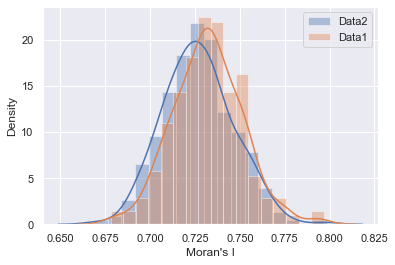

In [9]:
sns.distplot(Moran1,label = "Data2")
sns.distplot(Moran2,label = "Data1")
plt.ylabel("Density")
plt.xlabel("Moran's I")
plt.legend()

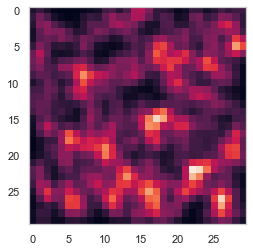

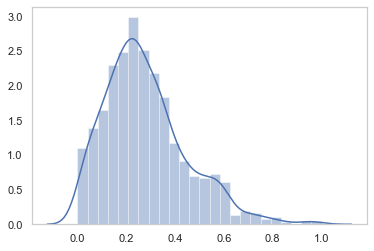

In [31]:
sns.set_style("whitegrid", {'axes.grid' : False})
plt.imshow(Data1[20])

plt.figure()
sns.distplot(Data1[20].flatten())

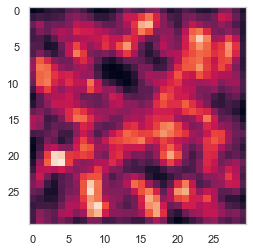

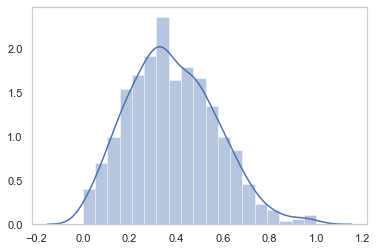

In [33]:
plt.imshow(Data2[70])
sns.set_style("whitegrid", {'axes.grid' : False})
plt.figure()
sns.distplot(Data2[70].flatten())

In [12]:
def logistic(t,a,b,c):
    return c/(1+a*np.exp(-b*t))


In [13]:
p0 = np.random.exponential(size = 3)
bounds = (0,[100000,20,2000])

In [40]:
import scipy.optimize as optim
x = thresh 
y = np.array(np.hstack(y2[150]))

(a,b,c),cov = optim.curve_fit(logistic,x,y,bounds = bounds, p0=p0)

In [41]:
a,b,c

(252.4376587294292, 11.619591502190096, 1.0051687153359687)

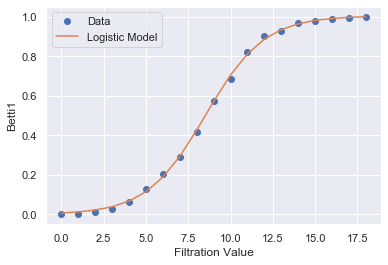

In [42]:
sns.set()

def my_log(t):
    return c/(1+a*np.exp(-b*t))

plt.plot(y,'o',label = "Data")
plt.plot(logistic(x,a,b,c), label = "Logistic Model")
plt.ylabel("Betti1")
plt.xlabel("Filtration Value")
plt.legend()

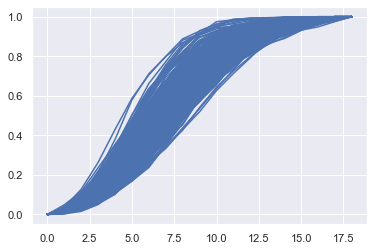

In [17]:
y1t = np.vstack(y1)
plt.plot(y1t.T,'b')



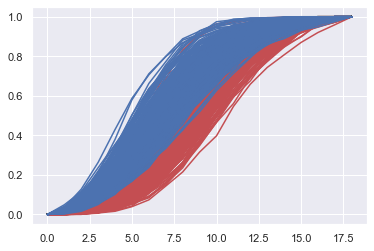

In [18]:
y2t = np.vstack(y2)
plt.plot(y2t.T,'r')
plt.plot(y1t.T,'b')

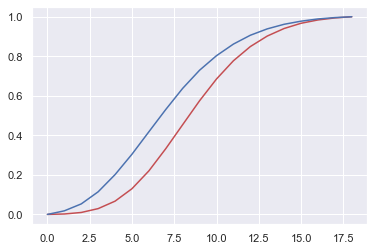

In [19]:
plt.plot(np.mean(y2t.T,axis = 1),'r')
plt.plot(np.mean(y1t.T,axis = 1),'b')

In [20]:
import scipy.optimize as optim
x = thresh 
y = np.mean(y2t.T,axis = 1)

(a,b,c),cov = optim.curve_fit(logistic,x,y,bounds = bounds, p0=p0)

In [21]:
a,b,c

(148.34610902138698, 10.576188599774838, 0.9954982596615206)

In [22]:
x = thresh 
y = np.mean(y1t.T,axis = 1)

(a,b,c),cov = optim.curve_fit(logistic,x,y,bounds = bounds, p0=p0)

In [23]:
a,b,c

(48.19938210208773, 9.915494490618476, 0.9896995057697235)

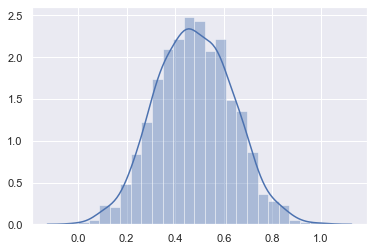

In [24]:
A = np.random.normal(.3,.3,(30,30))

A = (A - A.min())/(A.max() - A.min())

sns.distplot(A.flatten())

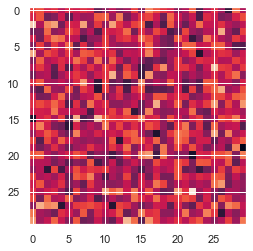

In [25]:
plt.imshow(A)

In [26]:
U = 30
M = make_matrix(U,U)
y = np.vstack(euler_char(A,U,U,thresh))
p0 = np.random.exponential(size = 3)
bounds = (0,[1000000000,30,20000])
x = thresh
y = np.array(np.hstack(y))
y = (y - y.min())/(y.max() - y.min())
(a,b,c),cov = optim.curve_fit(logistic,x,y,bounds = bounds, p0=p0)
param = [a,b,c]


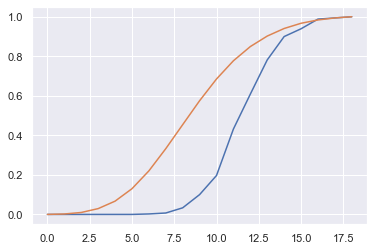

In [27]:
plt.plot(y)
plt.plot(np.mean(y2t.T,axis = 1))

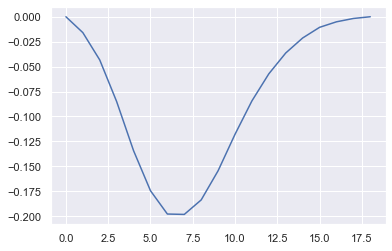

In [44]:
dif = np.mean(y2t.T,axis = 1) - np.mean(y1t.T,axis = 1)
plt.plot(dif)

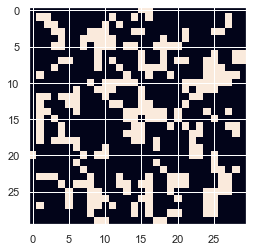

In [67]:
plt.imshow((Data1[197] <= .5)*1 - (Data1[197] <= .3)*1)

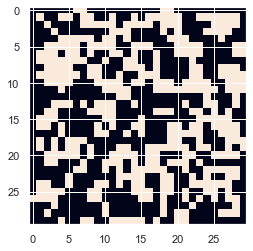

In [68]:
plt.imshow((Data2[278] <= .5)*1 - (Data2[278] <= .3)*1)

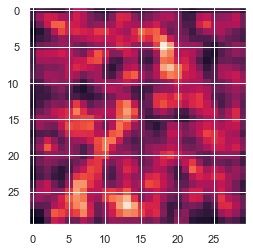

In [65]:
plt.imshow((Data2[278]))

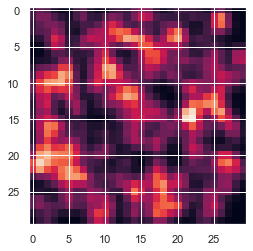

In [66]:
plt.imshow((Data1[197]))